In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
# Load Libraries and set directories
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import OneHotEncoder
wd = "/content/drive/MyDrive/Personal/Apziva"

For this project, I would recommend covering all the basics for modelling. Like EDA, feature engineering, evaluation metrics

This should include, confusion matrix, classification report, feature importance, ROC Curve
And it possible, Predicted Vs Observed charts

###Data Exploration

In [3]:
# Load data and check for NaNs
df = pd.read_csv(f"{wd}/ACME-HappinessSurvey2020.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


In [4]:
# X6 and X1 seem to be high in 0s
df

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5
...,...,...,...,...,...,...,...
121,1,5,2,3,4,4,3
122,1,5,2,3,4,2,5
123,1,5,3,3,4,4,5
124,0,4,3,3,4,4,5


Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers <BR>
X1 = my order was delivered on time <BR>
X2 = contents of my order was as I expected <br>
X3 = I ordered everything I wanted to order<br>
X4 = I paid a good price for my order <br>
X5 = I am satisfied with my courier <br>
X6 = the app makes ordering easy for me

In [5]:
# Adding extra features
#min score
df["AVG"] = df.loc[:,"X1":"X6"].mean(axis=1)
df["avg_X2_X5"] = df.loc[:,"X2":"X5"].mean(axis=1)
df["user_min"] = df.loc[:,"X1":"X6"].min(axis=1)
df.sample(15)

,Y,X1,X2,X3,X4,X5,X6,AVG,avg_X2_X5,user_min
12,1,5,2,4,5,5,5,4.333333,4.00,2
94,0,3,1,3,2,1,2,2.000000,1.75,1
8,0,4,1,4,4,4,4,3.500000,3.25,1
31,0,4,1,3,4,4,5,3.500000,3.00,1
4,0,5,4,3,3,3,5,3.833333,3.25,3
58,1,5,3,5,5,4,5,4.500000,4.25,3
102,0,5,2,3,3,3,5,3.500000,2.75,2
83,1,5,3,2,4,4,4,3.666667,3.25,2
60,0,4,3,3,3,3,5,3.500000,3.00,3
99,0,3,3,2,4,4,4,3.333333,3.25,2


In [ ]:
# df = df[~((df["Y"] == 1) & (df["avg_X2_X5"] < 2))]
# df = df[~((df['X1'] == 1) | (df['X6'] == 1)| (df['X2'] == 5)|(df['X3'] == 1))]
#https://imgur.com/a/Myv1UmI

In [ ]:
# df[((df["Y"] == 1) & (df["avg_X2_X5"] < 2))]

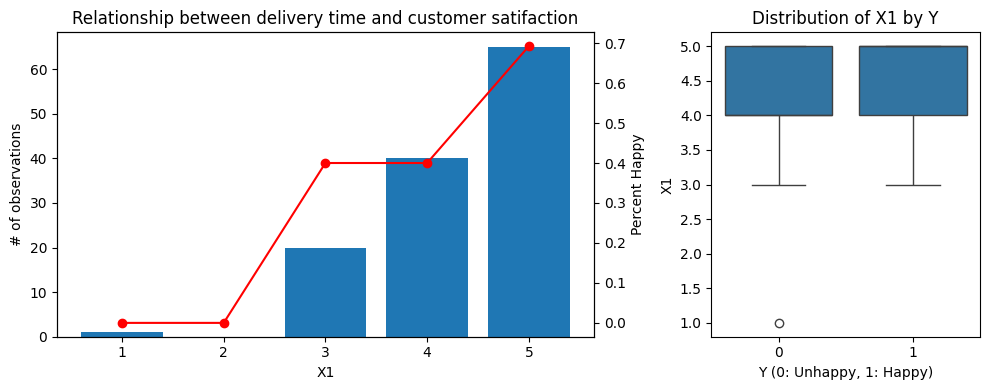

In [6]:
count_dict = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
count_dict.update(df['X1'].value_counts().to_dict())

fig, (ax_left, ax_right) = plt.subplots(
    ncols=2, figsize=(10, 4), gridspec_kw={'width_ratios': [2, 1]})
avg_y = df.groupby('X1')['Y'].mean()
avg_y = avg_y.reindex(range(1,6), fill_value=0)

ax_left.bar(count_dict.keys(), count_dict.values())
ax_left.set_xlabel('X1')
ax_left.set_ylabel('# of observations')
ax_left.set_title('Relationship between delivery time and customer satifaction')
ax2 = ax_left.twinx() #to add on same graph
ax2.plot(avg_y.index, avg_y.values, color='red', marker='o')
ax2.set_ylabel("Percent Happy")
sns.boxplot(x='Y', y='X1', data=df, ax=ax_right)
ax_right.set_title('Distribution of X1 by Y')
ax_right.set_xlabel('Y (0: Unhappy, 1: Happy)')
plt.tight_layout()
plt.show()

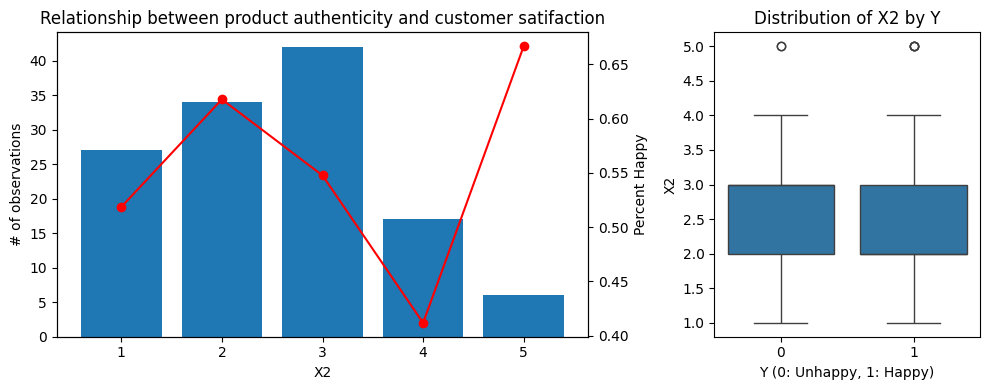

In [8]:
# Calculate count and y mean
count_dict = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
count_dict.update(df['X2'].value_counts().to_dict())
avg_y = df.groupby('X2')['Y'].mean()
avg_y = avg_y.reindex(range(1,6), fill_value=0)
#Set graph
fig, (ax_left, ax_right) = plt.subplots(
    ncols=2, figsize=(10, 4), gridspec_kw={'width_ratios': [2, 1]})
ax_left.bar(count_dict.keys(), count_dict.values())
ax_left.set_xlabel('X2')
ax_left.set_ylabel('# of observations')
ax_left.set_title('Relationship between product authenticity and customer satifaction')
ax2 = ax_left.twinx() #to add on same graph
ax2.plot(avg_y.index, avg_y.values, color='red',marker='o')
ax2.set_ylabel("Percent Happy")
sns.boxplot(x='Y', y='X2', data=df, ax=ax_right)
ax_right.set_title('Distribution of X2 by Y')
ax_right.set_xlabel('Y (0: Unhappy, 1: Happy)')
plt.tight_layout()
plt.show()

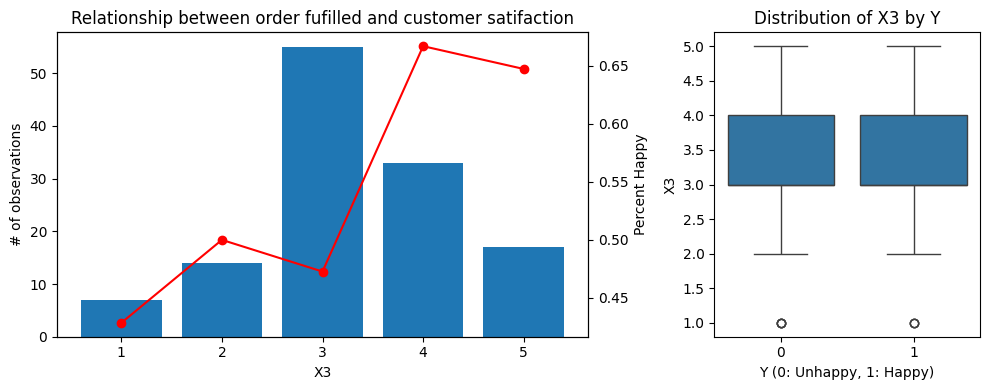

In [9]:
# Calculate count and y mean
count_dict = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
count_dict.update(df['X3'].value_counts().to_dict())
avg_y = df.groupby('X3')['Y'].mean()
avg_y = avg_y.reindex(range(1,6), fill_value=0)
#Set graph
fig, (ax_left, ax_right) = plt.subplots(
    ncols=2, figsize=(10, 4), gridspec_kw={'width_ratios': [2, 1]})
ax_left.bar(count_dict.keys(), count_dict.values())
ax_left.set_xlabel('X3')
ax_left.set_ylabel('# of observations')
ax_left.set_title('Relationship between order fufilled and customer satifaction')
ax2 = ax_left.twinx() #to add on same graph
ax2.plot(avg_y.index, avg_y.values, color='red',marker='o')
ax2.set_ylabel("Percent Happy")
sns.boxplot(x='Y', y='X3', data=df, ax=ax_right)
ax_right.set_title('Distribution of X3 by Y')
ax_right.set_xlabel('Y (0: Unhappy, 1: Happy)')
plt.tight_layout()
plt.show()

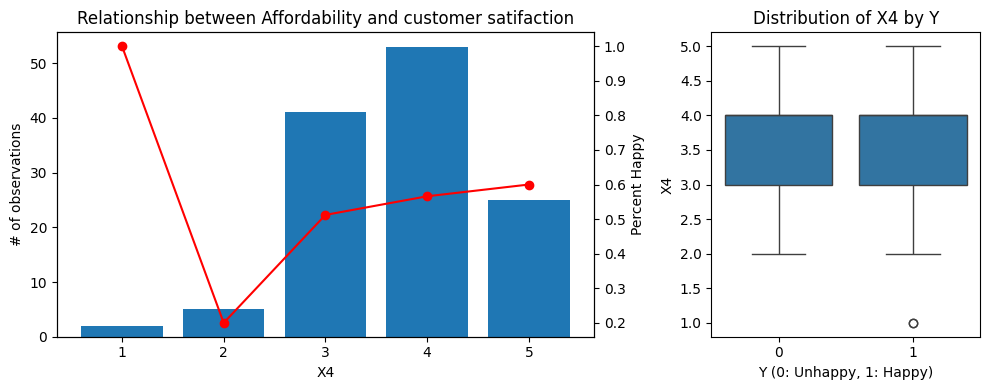

In [10]:
# Calculate count and y mean
count_dict = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
count_dict.update(df['X4'].value_counts().to_dict())
avg_y = df.groupby('X4')['Y'].mean()
avg_y = avg_y.reindex(range(1,6), fill_value=0)
#Set graph
fig, (ax_left, ax_right) = plt.subplots(
    ncols=2, figsize=(10, 4), gridspec_kw={'width_ratios': [2, 1]})
ax_left.bar(count_dict.keys(), count_dict.values())
ax_left.set_xlabel('X4')
ax_left.set_ylabel('# of observations')
ax_left.set_title('Relationship between Affordability and customer satifaction')
ax2 = ax_left.twinx() #to add on same graph
ax2.plot(avg_y.index, avg_y.values, color='red',marker='o')
ax2.set_ylabel("Percent Happy")
sns.boxplot(x='Y', y='X4', data=df, ax=ax_right)
ax_right.set_title('Distribution of X4 by Y')
ax_right.set_xlabel('Y (0: Unhappy, 1: Happy)')
plt.tight_layout()
plt.show()

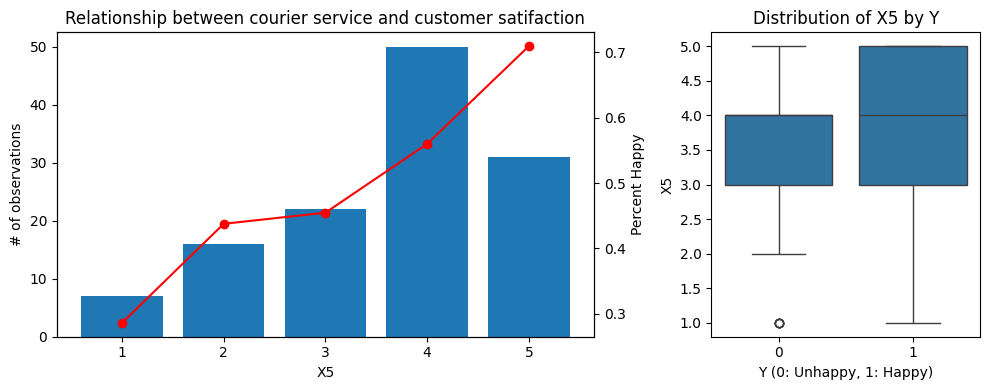

In [11]:
# Calculate count and y mean
count_dict = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
count_dict.update(df['X5'].value_counts().to_dict())
avg_y = df.groupby('X5')['Y'].mean()
avg_y = avg_y.reindex(range(1,6), fill_value=0)
#Set graph
fig, (ax_left, ax_right) = plt.subplots(
    ncols=2, figsize=(10, 4), gridspec_kw={'width_ratios': [2, 1]})
ax_left.bar(count_dict.keys(), count_dict.values())
ax_left.set_xlabel('X5')
ax_left.set_ylabel('# of observations')
ax_left.set_title('Relationship between courier service and customer satifaction')
ax2 = ax_left.twinx() #to add on same graph
ax2.plot(avg_y.index, avg_y.values, color='red',marker='o')
ax2.set_ylabel("Percent Happy")
sns.boxplot(x='Y', y='X5', data=df, ax=ax_right)
ax_right.set_title('Distribution of X5 by Y')
ax_right.set_xlabel('Y (0: Unhappy, 1: Happy)')
plt.tight_layout()
plt.show()

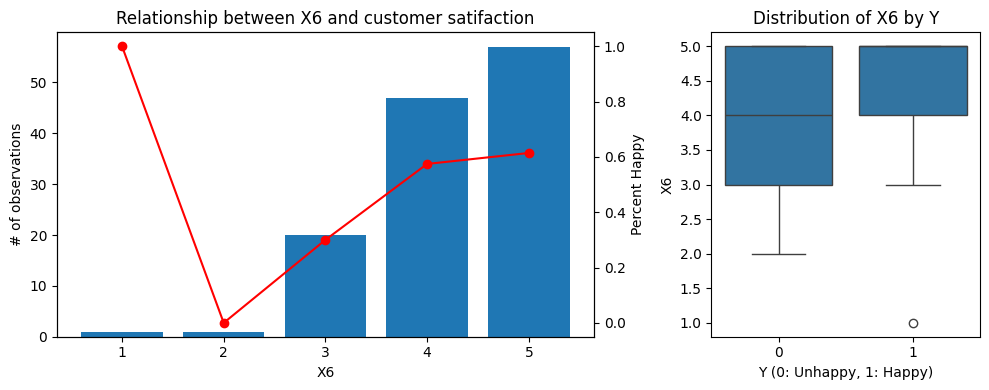

In [12]:
# Calculate count and y mean
count_dict = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
count_dict.update(df['X6'].value_counts().to_dict())
avg_y = df.groupby('X6')['Y'].mean()
avg_y = avg_y.reindex(range(1,6), fill_value=0)
#Set graph
fig, (ax_left, ax_right) = plt.subplots(
    ncols=2, figsize=(10, 4), gridspec_kw={'width_ratios': [2, 1]})
ax_left.bar(count_dict.keys(), count_dict.values())
ax_left.set_xlabel('X6')
ax_left.set_ylabel('# of observations')
ax_left.set_title('Relationship between X6 and customer satifaction')
ax2 = ax_left.twinx() #to add on same graph
ax2.plot(avg_y.index, avg_y.values, color='red',marker='o')
ax2.set_ylabel("Percent Happy")
sns.boxplot(x='Y', y='X6', data=df, ax=ax_right)
ax_right.set_title('Distribution of X6 by Y')
ax_right.set_xlabel('Y (0: Unhappy, 1: Happy)')
plt.tight_layout()
plt.show()

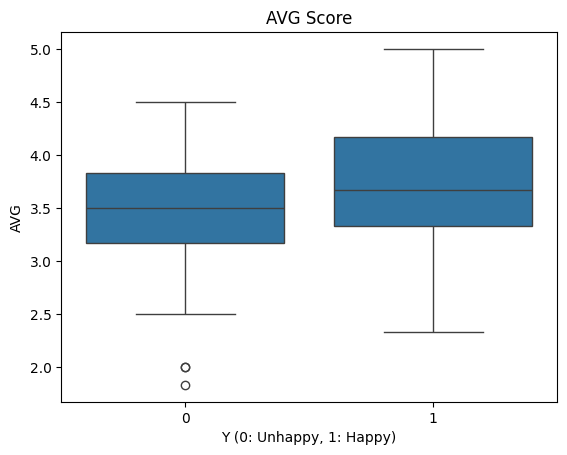

In [ ]:
sns.boxplot(x='Y', y='AVG', data=df)
plt.title('AVG Score')
plt.xlabel('Y (0: Unhappy, 1: Happy)')
plt.show()

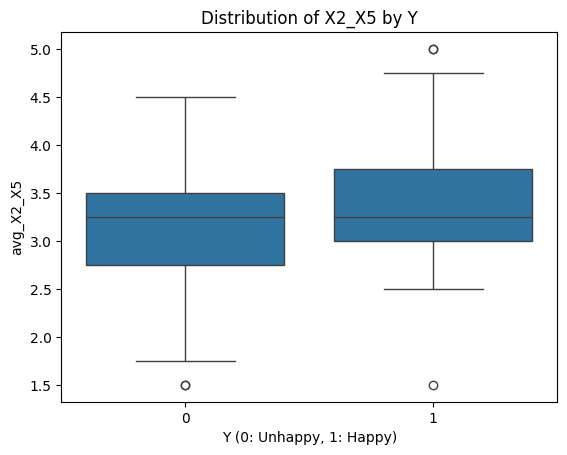

In [ ]:
sns.boxplot(x='Y', y='avg_X2_X5', data=df)
plt.title('Distribution of X2_X5 by Y')
plt.xlabel('Y (0: Unhappy, 1: Happy)')
plt.show()

###Data Prep

In [13]:
y = df["Y"]
x = df.iloc[:,1:]
x

,X1,X2,X3,X4,X5,X6,AVG,avg_X2_X5,user_min
0,3,3,3,4,2,4,3.166667,3.00,2
1,3,2,3,5,4,3,3.333333,3.50,2
2,5,3,3,3,3,5,3.666667,3.00,3
3,5,4,3,3,3,5,3.833333,3.25,3
4,5,4,3,3,3,5,3.833333,3.25,3
...,...,...,...,...,...,...,...,...,...
121,5,2,3,4,4,3,3.500000,3.25,2
122,5,2,3,4,2,5,3.500000,2.75,2
123,5,3,3,4,4,5,4.000000,3.50,3
124,4,3,3,4,4,5,3.833333,3.50,3


In [14]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

###XGBoost

In [15]:
# create model instance
bst = XGBClassifier(n_estimators=1000, max_depth=5, learning_rate=.1, objective='binary:logistic', num_parallel_tree = 2, subsample = 0.5)
# fit model
bst.fit(X_train, y_train)
# make predictions
y_pred_train = bst.predict(X_train)
y_preds_test = bst.predict(X_test)

**Metrics**

Train
Test


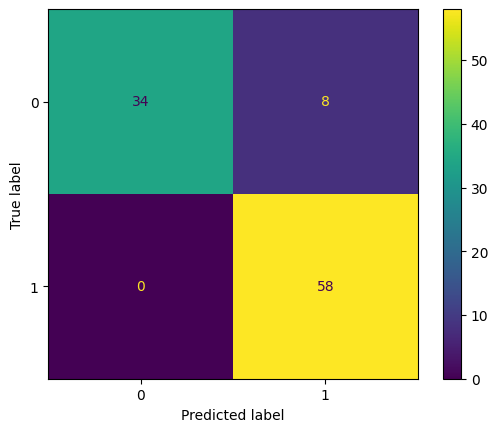

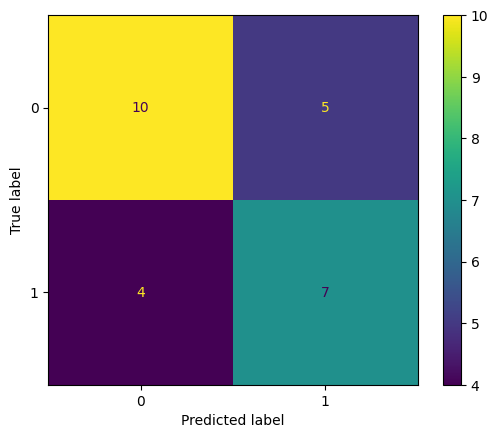

In [22]:
print("Train")
cm_train = confusion_matrix(y_train, y_pred_train, labels=bst.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=bst.classes_)
disp.plot()
print("Test")
cm_test = confusion_matrix(y_test, y_preds_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=bst.classes_)
disp_test.plot()
plt.show()

In [16]:
print("Train Metrics")
print(classification_report(y_train, y_pred_train))
print("Test Metrics")
print(classification_report(y_test, y_preds_test))

Train Metrics
              precision    recall  f1-score   support

           0       1.00      0.81      0.89        42
           1       0.88      1.00      0.94        58

    accuracy                           0.92       100
   macro avg       0.94      0.90      0.92       100
weighted avg       0.93      0.92      0.92       100

Test Metrics
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        15
           1       0.58      0.64      0.61        11

    accuracy                           0.65        26
   macro avg       0.65      0.65      0.65        26
weighted avg       0.66      0.65      0.66        26



In [ ]:
# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [26]:
bst.predict_proba(X_test)[:, 1]

array([0.9554875 , 0.6268299 , 0.00149706, 0.27593768, 0.02084074,
       0.82711643, 0.12093306, 0.9400129 , 0.95889837, 0.34036174,
       0.1558102 , 0.43320215, 0.99117416, 0.8641453 , 0.1899727 ,
       0.35997242, 0.81499606, 0.03200217, 0.77603775, 0.01698345,
       0.11385054, 0.1656908 , 0.5955523 , 0.15066433, 0.9610503 ,
       0.8523377 ], dtype=float32)

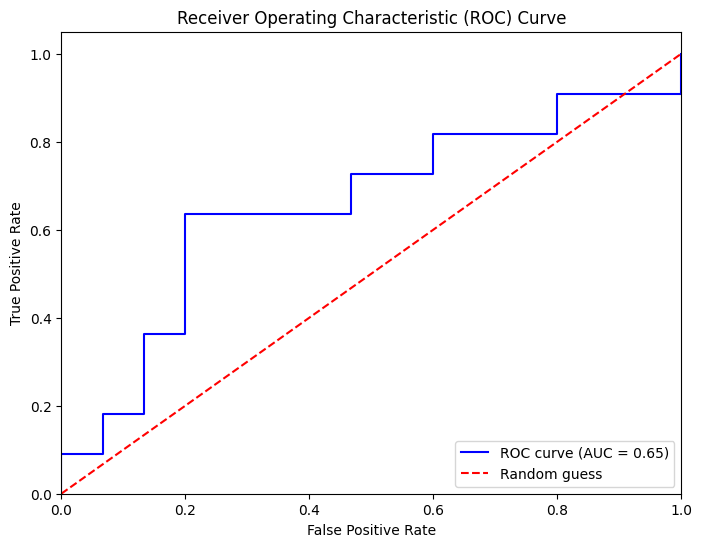

In [27]:
from sklearn.metrics import roc_curve, auc
y_pred_proba = bst.predict_proba(X_test)[:, 1]
# Calculate ROC curve and AUC for test set
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

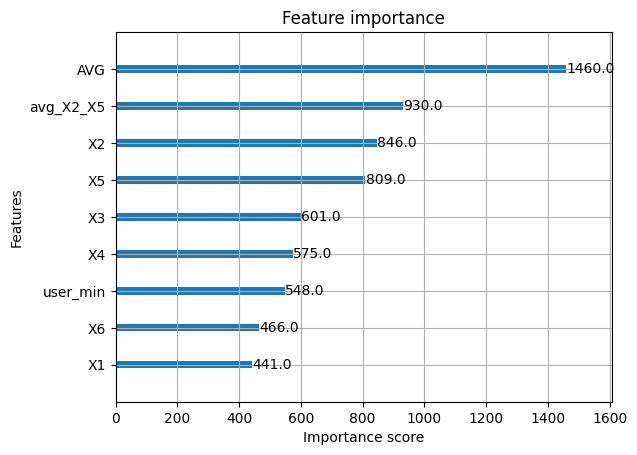

In [ ]:
#AUC/ROC
#Predicted vs. Observed
plot_importance(bst)
plt.show()